# Logistic Regression with a Neural Network mindset

简单的神经网络（1 hidden layer，1 hidden unit， sigmoid activation）

1. 准备数据（h5py）
2. 构建神经网络模型，FP/BP
3. 训练、预测
4. 调参，学习曲线
5. 其他

## 1 准备数据

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

In [2]:
# load data

train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
train_set_x_raw = np.array(train_dataset["train_set_x"][:]) 
train_set_y_raw = np.array(train_dataset["train_set_y"][:]) 

test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
test_set_x_raw = np.array(test_dataset["test_set_x"][:]) # your test set features
test_set_y_raw = np.array(test_dataset["test_set_y"][:]) # your test set labels

classes = np.array(test_dataset["list_classes"][:]) # the list of classes

print(train_set_x_raw.shape)
print(train_set_y_raw.shape)
print(classes)


(209, 64, 64, 3)
(209,)
[b'non-cat' b'cat']


训练集有209个， 64x64 个像素， 3原色

y = 0, it's a 'non-cat' picture.


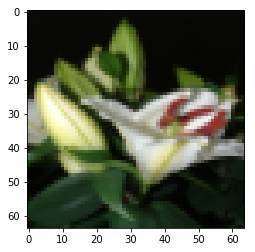

In [3]:
def show_image(x, y):
    plt.imshow(x)
    y = np.squeeze(y)
    c = classes[y].decode("utf-8")
    print ("y = " + str(y) + ", it's a '" + c +  "' picture.")

index = 4

show_image(train_set_x_raw[index], train_set_y_raw[index])

In [4]:
# reshape, normalize
train_set_x = train_set_x_raw.reshape(train_set_x_raw.shape[0], -1).T / 255.
train_set_y = train_set_y_raw.reshape(1, -1)

test_set_x = test_set_x_raw.reshape(test_set_x_raw.shape[0], -1).T / 255.
test_set_y = test_set_y_raw.reshape(1, -1)

print ("train_set_x_flatten shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


## 2 准备模型

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$


In [8]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

class SimpleNN():
    def __init__(self):
        self.initialize_parameters(1)
    
    def initialize_parameters(self, n_0):
        self.n_0 = n_0
        self.w = np.zeros((n_0, 1))
        self.b = np.zeros((1, 1))
        
    def propagate(self, X, Y):
        m = X.shape[1]
        w = self.w
        b = self.b
        A = sigmoid(np.dot(w.T, X) + b)   # A(1, m)
        cost = -(np.dot(np.log(A), Y.T) + np.dot(np.log(1 - A), 1 - Y.T)) / m
        
        dZ = A - Y
        dw = np.dot(X, dZ.T) / m
        db = np.sum(A - Y) / m 
        
        cost = np.squeeze(cost)
        grads = {"dw": dw,
                 "db": db}
        return grads, cost
    
    def fit(self, X, Y, num_iterations=2000, learning_rate=0.5, print_cost=False):
        self.initialize_parameters(X.shape[0])
        costs = []
        for i in range(num_iterations):
            grads, cost = self.propagate(X, Y)
            
            dw = grads["dw"]
            db = grads["db"]

            self.w -= learning_rate * dw
            self.b -= learning_rate * db
            
            if i % 100 == 0:
                costs.append(cost)

            # Print the cost every 100 training examples
            if print_cost and i % 100 == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
                
        return costs
    
    def predict(self, X):
        m = X.shape[1]
        prediction = np.zeros((1, m))
        
        A = sigmoid(np.dot(self.w.T, X) + self.b) 
        prediction = (A > 0.5).astype(int)
        
        return prediction
    
    def score(self, X, Y):
        prediction = self.predict(X)
        return 1.0 * np.sum(prediction == Y) / prediction.shape[1]


bugfix： 在predict里面  `A = sigmoid(np.dot(self.w.T, X) + self.b) ` 写成 `A = sigmoid(np.dot(self.w.T, X) + b)` ，用成全局的了，还不知道，调了好长时间 

In [13]:
who

Image	 SimpleNN	 classes	 costs	 frame	 h5py	 i	 index	 learning_rate	 
learning_rates	 legend	 model	 models	 ndimage	 np	 plt	 prediction	 scipy	 
show_image	 sigmoid	 snn	 test_dataset	 test_set_x	 test_set_x_raw	 test_set_y	 test_set_y_raw	 train_dataset	 
train_set_x	 train_set_x_raw	 train_set_y	 train_set_y_raw	 


## 3 训练模型

In [9]:
snn = SimpleNN()

learning_rate = 0.005
costs = snn.fit(train_set_x, train_set_y, learning_rate=learning_rate, print_cost=True)

# Print train/test Errors
print("train accuracy: {} %".format(100 * snn.score(train_set_x, train_set_y)))
print("test accuracy: {} %".format(100 * snn.score(test_set_x, test_set_y)))

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


**Expected Output**: 

<table style="width:40%"> 

    <tr>
        <td> **Cost after iteration 0 **  </td> 
        <td> 0.693147 </td>
    </tr>
      <tr>
        <td> <center> $\vdots$ </center> </td> 
        <td> <center> $\vdots$ </center> </td> 
    </tr>  
    <tr>
        <td> **Train Accuracy**  </td> 
        <td> 99.04306220095694 % </td>
    </tr>

    <tr>
        <td>**Test Accuracy** </td> 
        <td> 70.0 % </td>
    </tr>
</table> 




y = 1, it's a 'cat' picture.


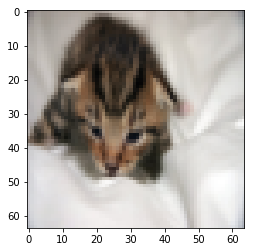

In [10]:
# Example of a picture that was wrongly classified.
index = 1
prediction = snn.predict(test_set_x)

show_image(test_set_x[:, index].reshape(64, 64, 3),
           prediction[0, index])

## 4 学习曲线， 调参

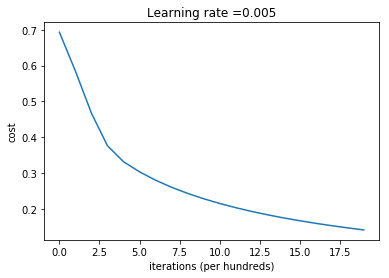

In [11]:
# Plot learning curve (with costs)
costs = np.squeeze(costs)
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(learning_rate))
plt.show()

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



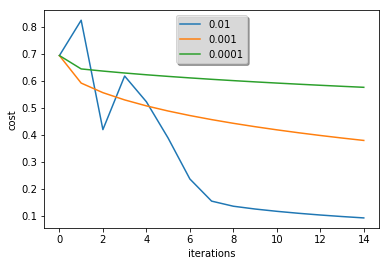

In [12]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    model = SimpleNN()
    costs = model.fit(train_set_x, train_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    models[str(i)] = costs
    print("train accuracy: {} %".format(100 * model.score(train_set_x, train_set_y)))
    print("test accuracy: {} %".format(100 * model.score(test_set_x, test_set_y)))
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    costs = models[str(i)]
    plt.plot(np.squeeze(costs), label= str(i))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

In [ ]:
my_image = "images/my_image2.jpg"   # change this to the name of your image file 
num_px = 64
image = np.array(ndimage.imread(my_image, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = snn.predict(my_image)

show_image(image, my_predicted_image)